# Quality control of sc/snRNA-seq

To perform quality control of single-cell or single-nuclei RNA sequencing (sc/snRNA-seq) we have the `dotools_py.pp.importer_py()` function. This function compiles different methods to process samples. We need to define a list of H5 files that have been generated from a mapping tool like [CellRanger](https://www.10xgenomics.com/support/software/cell-ranger/latest) or [STARsolo](https://github.com/cellgeni/STARsolo). If [CellBender](https://github.com/broadinstitute/CellBender) has been run, we can also provide the path to the H5 files generated by CellBender. Additionally, we need to provide the batch names for the samples, and additional metadata can be provided in the form of a dictionary.

The quality control involves filtering genes and cells:
- **Genes**: are removed based on their expression levels. Genes expressed in low amount of cells are excluded. By default, we consider that a gene is excluded if it is expressed in less than 5 cells
- **Cells**: are removed based on different parameters, including: number of genes, mitochondrial content, doublets and number of UMI counts.
    - Mitochondrial content: cells with high mitochondrial content are excluded. We recomment assuming a maximum un 5 % for scRNA-seq and 3% for snRNA-seq
    - Doublets: we implemented three different approaches for the identification of neotypic doublets (i.e, doublets originating from the combination of two or more different cell-types). The available implementations are [scDblFinder](https://github.com/plger/scDblFinder), [DoubletDetection](https://github.com/JonathanShor/DoubletDetection) and [Scrublet](https://github.com/swolock/scrublet).
    - Number of genes: cells are removed by absolute number of genes. A lower and upper threshold can be set.
    - Number of UMI counts: cells can be removed using two approaches: absolute or quantiles. A lower and upper threshold can be set and a combination of both approaches can be used (e.g., an absolute lower threshold and filter cells on the upper quantile).

After the quality control per sample, the individual samples will be combined into one AnnData object and log-normalisation, scaling and highly variable genes  will be calculated. To evaluate the quality control the distribution of total UMI, number of genes and mitochondrial genes per cell will be plotted in a violin plot before and after the quality control. These plots will be saved in the folders containing the H5 files. Additionally, we also keep track on the number of cells and genes that have been removed in each quality control step.

First, we start setting up the environment and loading the required libraries

## Environment setup

In [1]:
import dotools_py as do
import pandas as pd
from IPython.display import display, SVG
import session_info

2025-10-22 16:16:29,365 - Jupyter enviroment detected. Using "inline" backend


To show how the quality control works, we are going to use a public dataset from 10X from human blood of healthy and donors with a malignant tumor. We get the raw and the filtered H5 files generated by 10X.


In [2]:
do.dt.example_10x("/Users/david/Downloads/PublicData10x")

2025-10-22 16:16:29,452 - Downloading data to /Users/david/Downloads/PublicData10x


## Sequential preprocessing

In [3]:
paths = [
    "/Users/david/Downloads/PublicData10x/healthy/outs/filtered_feature_bc_matrix.h5",
    "/Users/david/Downloads/PublicData10x/disease/outs/filtered_feature_bc_matrix.h5",
]

adata = do.pp.importer_py(
    paths=paths,
    ids=["batch1", "batch2"],
    metadata={"condition": ["healthy", "disease"]},  # Additional metadata information
    batch_key="batch",  # Column in obs to save batch information
    remove_doublets=True,
    doublet_tool="scDblFinder",  # Tool to identify neotypic doublets (Also available Scrublet and DoubletDetection)
    min_genes_in_cell=300,
    min_cells_with_genes=5,
    cut_mt=5,
    n_reads=10_000,
    min_counts=500,  # Filter cells with less than 500 genes
    high_quantile=95,  # Filter cells with the top 5% high number of UMI counts
)

2025-10-22 16:16:33,139 - Reading batch1
2025-10-22 16:16:33,896 - Remove Cells with low number of genes
2025-10-22 16:16:33,943 - Remove Genes lowly expressed
2025-10-22 16:16:34,007 - Remove cells with high MT-content
2025-10-22 16:16:34,025 - Remove cells based on nUMI counts
2025-10-22 16:16:34,340 - Finding Neotypic doublets
2025-10-22 16:16:34,409 - Running scDblFinder


Reading AnnData in R
Finding doublets per batch...


2025-10-22 16:16:51,987 - Remove 86 doublets


Exporting to Python


2025-10-22 16:16:52,346 - Reading batch2
2025-10-22 16:16:52,840 - Remove Cells with low number of genes
2025-10-22 16:16:52,878 - Remove Genes lowly expressed
2025-10-22 16:16:52,932 - Remove cells with high MT-content
2025-10-22 16:16:52,937 - Remove cells based on nUMI counts
2025-10-22 16:16:52,944 - Finding Neotypic doublets
2025-10-22 16:16:52,978 - Running scDblFinder


Reading AnnData in R
Finding doublets per batch...


2025-10-22 16:17:09,388 - Remove 26 doublets


Exporting to Python


2025-10-22 16:17:09,571 - Concatenating samples
2025-10-22 16:17:09,653 - Normalisation of the expression
2025-10-22 16:17:09,675 - Finding Highly Variable Genes shared across samples
2025-10-22 16:17:09,970 - Run PCA


In [4]:
adata

AnnData object with n_obs × n_vars = 2783 × 18517
    obs: 'batch', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'doublet_class', 'doublet_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'logcounts'

## Evaluation of the preprocessing

We can now check the quality control plots that were generated:


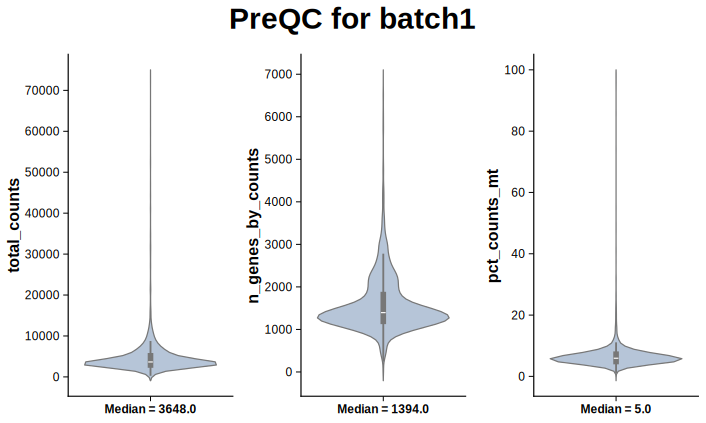

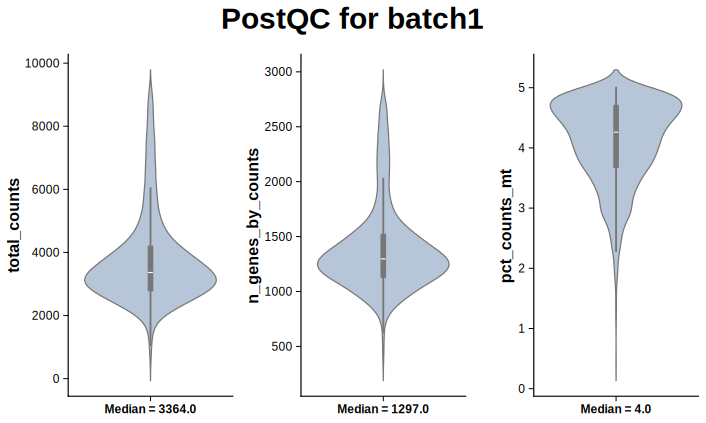

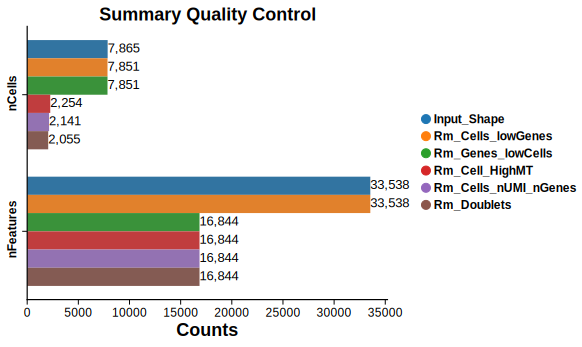

In [5]:
files = [
    "/Users/david/Downloads/PublicData10x/healthy/outs/Vln_PreQC_batch1.svg",
    "//Users/david/Downloads/PublicData10x/healthy/outs/Vln_PostQC_batch1.svg",
    "/Users/david/Downloads/PublicData10x/healthy/outs/251022_QC_Metricsbatch1.svg"
]

display(
    SVG(files[0]),
    SVG(files[1]),
    SVG(files[2]),
)

We can observe that the majority of cells were remove due to high mitochondrial content. Depending on the experimental set-up we might want to increase the threshold of mitochondrial content if we do not want to lose too many cells. Besides these plots, we also have an ExcelSheet that kept track on the thresholds used during the quality control.

In [6]:
table = pd.read_excel("/Users/david/Downloads/PublicData10x/healthy/outs/251022_Metrics_batch1.xlsx")
table

QC_Step  nCells  nFeatures  \
0           Input_Shape    7865      33538   
1     Rm_Cells_lowGenes    7851      33538   
2     Rm_Genes_lowCells    7851      16844   
3        Rm_Cell_HighMT    2254      16844   
4  Rm_Cells_nUMI_nGenes    2141      16844   
5           Rm_Doublets    2055      16844   

                                            Comments  
0                                                NaN  
1                       Remove cells with <300 genes  
2          Remove genes express in less than 5 cells  
3       Remove cells with >5% of Mitochondrial genes  
4  Remove cells based on nUMI counts[Absolute (Mi...  
5         Remove neotypic doublets using scDblFinder

## Integration and clustering
After the quality control, we can now proceed to the batch correction and integration of the samples. For these, we can use different batch correction methods: [Harmony](https://www.nature.com/articles/s41592-019-0619-0), [Scanorama](https://www.nature.com/articles/s41596-024-00991-3), [BBKNN](https://academic.oup.com/bioinformatics/article/36/3/964/5545955?login=true), [scVI](https://www.nature.com/articles/s41587-021-01206-w) or [CCA](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub) from Seurat (v4 or v5 approach). After the integration of the samples, we run the [Leiden](https://www.nature.com/articles/s41598-019-41695-z) algorithm to find clusters and generate the UMAP embeddings for visualisation.

In [7]:
do.tl.integrate_data(
    adata,
    batch_key="batch",
    hvg_batch=True,
    cca5=True,
    resolution=0.3,  # Resolution for leiden algorithm
)

2025-10-22 16:17:10,416 - Computing HVGs
2025-10-22 16:17:11,051 - Integration using CCA (Seurat v5 approach)
2025-10-22 16:17:11,053 - Preprocessing to export to Seurat
2025-10-22 16:17:11,069 - Running CCA Integration


Reading AnnData in R
Warning messages:
1: `PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>. 
2: The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>. 
3: Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_ to Xpca_ 
Starting ACC in R environment...
Run CCA with v5
Centering and scaling data matrix
  |======================================================================| 100%
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 2720 anchors
Merging dataset 2 into 1
Extracting anchors for merged 

                          integratedcca_1 integratedcca_2 integratedcca_3
AAACCCAGTGCATTTG-1-batch1      -29.240194       0.4496809        4.260958
AAACCCATCTCAACGA-1-batch1        4.484761      -1.2218207        4.033311
AAACCCATCTCTCGAC-1-batch1        4.340738      -1.4006172        3.692713
2025-10-22 16:17:31,545 - Loading corrected matrix
2025-10-22 16:17:31,577 - Finding neighbors


***************************************|
Integrating data
Warning messages:
1: Input is a v3 assay and `split()` only works for v5 assays; converting
• to a v5 assay 
2: The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>. 
Preparing to export to python...
Saving data in 
/tmp/CCA_cfd83d38bdba42af91b4b7ec7a081d6a/adata_hvg_seurat_AnchorIntegration.csv


2025-10-22 16:17:33,748 - Run UMAP
2025-10-22 16:17:36,709 - Clustering cells using Leiden (resolution 0.3)


 We can observe, that after the integration we have `X_CCA` in `obsm`. This is the CCA matrix after dimensionality reduction. Contrary to the approach in Seurat4 where  the dimensions of this matrix is  n_cells x n_hvg, in this case the dimension is n_cells x 50

In [8]:
adata.obsm["X_CCA"].shape

(2783, 50)

## Evaluation of integration
We can now visualise the integrated object and the identified clusters:

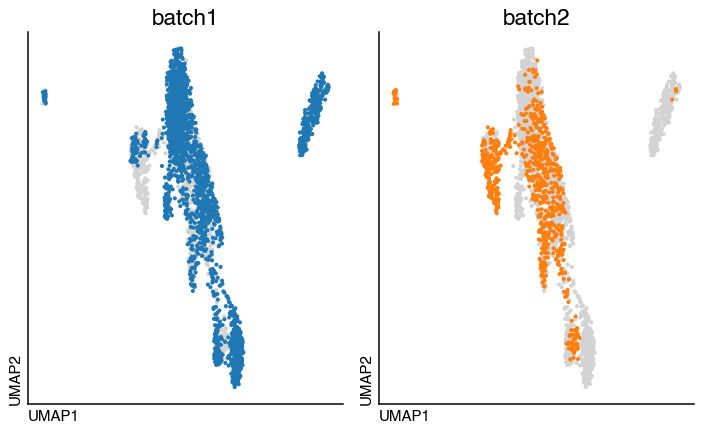

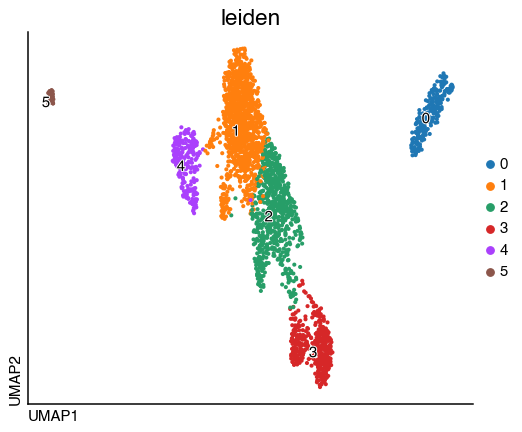

In [9]:
do.pl.split_embeddding(adata, "batch", figsize=(8, 5))
do.pl.umap(adata, "leiden", labels="leiden", figsize=(6, 5))

In [10]:
adata.write("/Users/david/Downloads/PublicData10x/adata.h5ad")

## Semi-automatic annotation with CellTypist

We also have the possibility to perform a semi-automatic annotation using [CellTypist](https://www.celltypist.org/). In this case, we use the  `Adult_COVID19_PBMC.pkl` model.

🔬 Input data has 2783 cells and 18517 genes
🔗 Matching reference genes in the model
🧬 3323 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


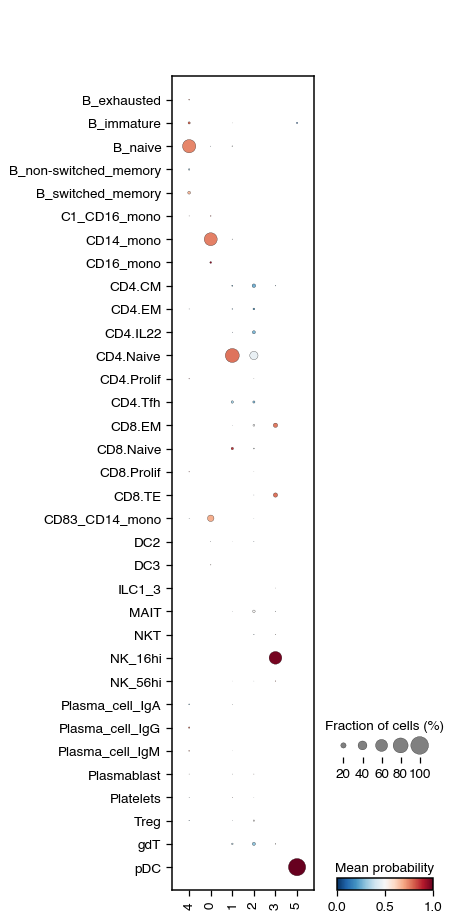

In [11]:
do.tl.auto_annot(adata, "leiden", model="Healthy_COVID19_PBMC.pkl", convert=False, pl_cell_prob=True)

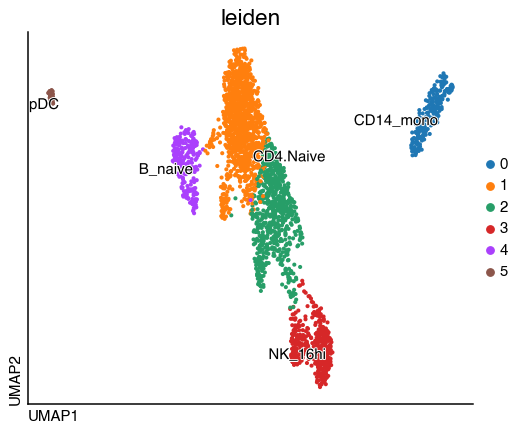

In [12]:
do.pl.umap(adata, "leiden", labels="autoAnnot")

Besides the semi-automatic annotation, we should also validate the findings with  known markers for these celltypes.


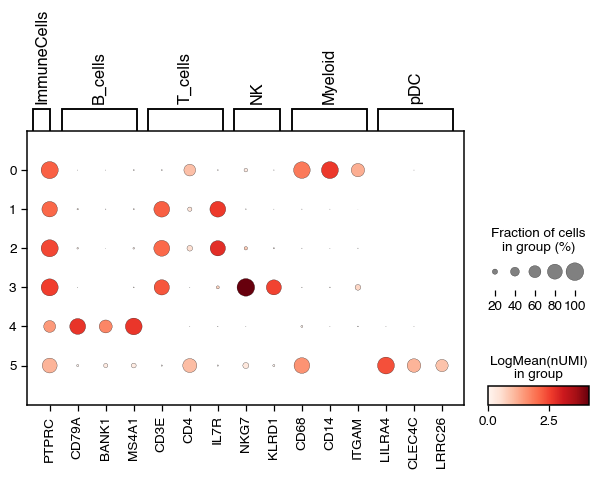

In [13]:
markers = {
    "ImmuneCells": ["PTPRC"],
    "B_cells": ["CD79A", "BANK1", "MS4A1"],
    "T_cells": ["CD3E", "CD4", "IL7R"],
    "NK": ["NKG7", "KLRD1"],
    "Myeloid": ["CD68", "CD14", "ITGAM"],
    "pDC": ["LILRA4", "CLEC4C", "LRRC26"],
}

do.pl.dotplot(adata, "leiden", markers, swap_axes=False, var_group_rotation=90)

Overall we can see an agreement with the annotation and can continue with the annotation.

... storing 'annotation' as categorical


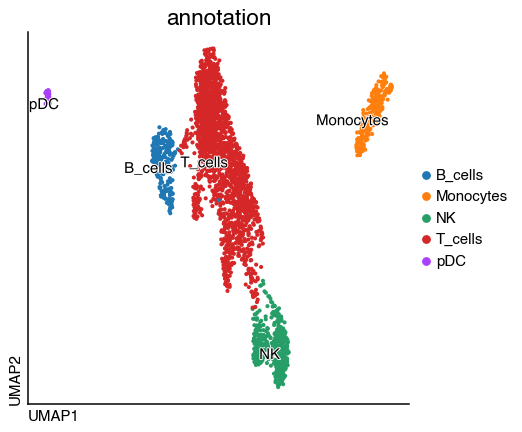

In [14]:
adata.obs["annotation"] = adata.obs.leiden.map(
    {"0": "Monocytes", "1": "T_cells", "2": "T_cells", "3": "NK", "4": "B_cells", "5": "pDC"}
)
do.pl.umap(adata, "annotation", labels="annotation")

## Evaluate changes in cell population
After the annotation of the cell-type populations, we can also evaluate if there are significant changes in these populations in the healthy and diseased condition using [scanpro](https://github.com/loosolab/scanpro).

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 3 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 0.99 seconds
2025-10-22 16:17:55,491 - There are 3 populations with a significant change


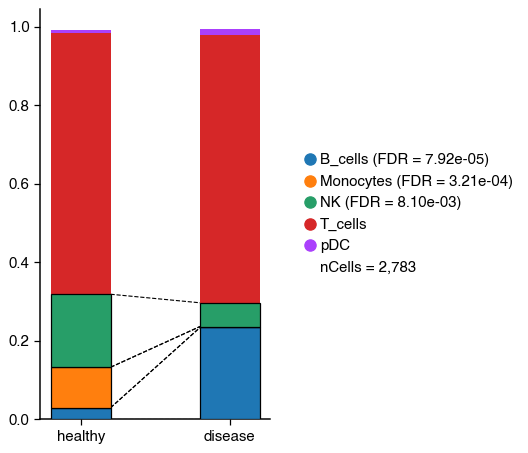

In [15]:
do.pl.cell_composition(
    adata,
    annot_key="annotation",
    cond_key="condition",
    batch_key="batch",
    transform="arcsin",  # Produce more accurate results for simulated data
    condition_order=["healthy", "disease"],
)

Cell populations with a significant change are connected by discontinued lines and the p-value is indicated in the legend. In this case, we see a significant change in B cells, Monocytes and NK cells.

## Reclustering of a cell population

If we are interested in specific states for a cell-type, we can also perform re-clustering. In this case, we are going to focus on the biggest cluster, the T cells.

2025-10-22 16:22:43,257 - annotation_recluster will be overwritten
2025-10-22 16:22:43,268 - Reclustering using CCA5 approach


... storing 'annotation_recluster' as categorical


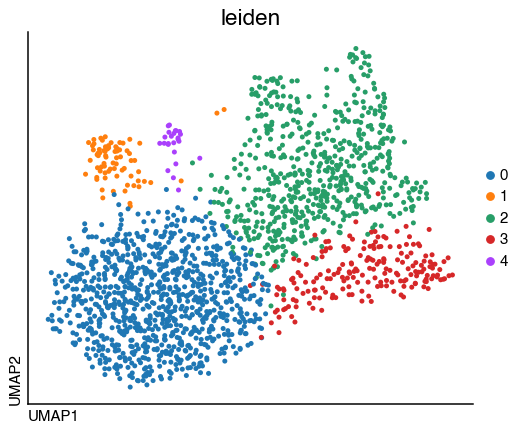

In [24]:
tcell = do.tl.reclustering(
    adata,
    cluster_key="annotation",  # Metadata column with clusters
    batch_key="batch",  # Metadata column with batch information
    recluster_apporach="cca5",  # Integration approach used
    use_clusters=["T_cells"],  # Cluster we want to re-cluster
    use_rep="X_CCA",  # representation to use
    get_subset=True,  # Get AnnData of T_cells re-clusters
    resolution=0.6,
)
do.pl.umap(tcell, "leiden")

We identified 5 clusters, to evaluate if there are subtypes of T_cells we can identify the top markers for each cluster.

In [26]:
do.tl.rank_genes_groups(tcell, groupby="leiden", method="wilcoxon", tie_correct=True, pts=True)
table = do.get.dge_results(tcell)
table_filt = table[(table.log2fc > 0.25) & (table.padj < 0.05)]

for group in table_filt.group.unique():
    display(table_filt[table_filt.group == group].head(6))

group GeneName  wilcox_score    log2fc          pvals           padj  \
0     0    RPS3A     24.965307  0.591396  1.456458e-137  2.696923e-133   
1     0    RPS13     24.810595  0.664970  6.890172e-136  4.252844e-132   
2     0    RPL30     22.808558  0.455121  3.770908e-115  1.396518e-111   
3     0    RPL32     22.482384  0.463160  6.173390e-112  1.905211e-108   
4     0    RPS23     22.206753  0.486430  2.955463e-109  7.818045e-106   
5     0   RPS27A     21.341381  0.439174  4.688915e-101   1.085308e-97   

   pts_group   pts_ref  
0   0.998952  0.995619  
1   0.997904  0.995619  
2   1.000000  0.995619  
3   1.000000  0.996714  
4   1.000000  0.995619  
5   1.000000  0.995619

group   GeneName  wilcox_score    log2fc          pvals           padj  \
18517     1  LINC02446     34.184128  6.524057  4.162212e-256  7.707169e-252   
18518     1       CD8B     32.883751  5.815713  3.752366e-237  3.474128e-233   
18519     1       CD8A     29.624027  5.087067  7.329576e-193  4.524059e-189   
18520     1      CD8B2     15.841774  7.049018   1.602366e-56   7.417755e-53   
18521     1       CTSW     14.294889  2.647650   2.354791e-46   8.720735e-43   
18522     1      S100B     11.258095  5.809854   2.112769e-29   6.520357e-26   

       pts_group   pts_ref  
18517   0.821918  0.009476  
18518   0.958904  0.025084  
18519   0.808219  0.021182  
18520   0.164384  0.001115  
18521   0.726027  0.129877  
18522   0.123288  0.003344

group GeneName  wilcox_score    log2fc          pvals           padj  \
37034     2    ANXA1     22.154280  2.242573  9.486497e-109  1.756615e-104   
37035     2      B2M     20.324232  0.452009   7.850685e-92   7.268556e-88   
37036     2   S100A4     20.198523  1.883775   1.008713e-90   6.226114e-87   
37037     2    ITGB1     18.013584  1.975382   1.524329e-72   4.704333e-69   
37038     2  S100A11     17.528395  1.584508   8.698970e-69   2.301126e-65   
37039     2    ANXA2     16.908760  2.318137   3.877802e-64   7.978363e-61   

       pts_group   pts_ref  
37034   0.744783  0.242765  
37035   1.000000  0.999196  
37036   0.855538  0.509646  
37037   0.568218  0.164791  
37038   0.691814  0.295016  
37039   0.399679  0.072347

group GeneName  wilcox_score    log2fc          pvals          padj  \
55551     3    IKZF2     21.439062  3.990067  5.776706e-102  1.069673e-97   
55552     3    RTKN2     19.659430  3.815890   4.800974e-86  4.444981e-82   
55553     3    TIGIT     18.316952  2.897526   6.061429e-75  3.741316e-71   
55554     3    FOXP3     17.922539  4.867512   7.865529e-72  3.641150e-68   
55555     3    CTLA4     16.903746  2.850002   4.222203e-64  1.563651e-60   
55556     3   PMAIP1     15.972801  2.978600   1.977037e-57  6.101466e-54   

       pts_group   pts_ref  
55551   0.471503  0.034050  
55552   0.455959  0.043011  
55553   0.544041  0.080645  
55554   0.284974  0.013740  
55555   0.497409  0.080048  
55556   0.528497  0.109916

group   GeneName  wilcox_score     log2fc          pvals           padj  \
74068     4       MYL9     23.222256  31.723900  2.713621e-119  5.024813e-115   
74069     4      PTCRA     21.493868  31.799917  1.776754e-102   1.645008e-98   
74070     4       SPIB     20.267651   6.568335   2.482264e-91   1.532136e-87   
74071     4       ACY3     19.442804   6.555577   3.353267e-84   1.552311e-80   
74072     4  LINC01857     19.355385   6.336043   1.836193e-83   6.800157e-80   
74073     4        GSN     19.210054   7.703021   3.049471e-82   9.411177e-79   

       pts_group   pts_ref  
74068   0.291667  0.000000  
74069   0.250000  0.000000  
74070   0.375000  0.003256  
74071   0.416667  0.005426  
74072   0.333333  0.002713  
74073   0.458333  0.007596

From the list of markers, cluster 3 seems to express markers for T regulatory cells. while cluster 1 seems to be enriched in cytotoxic markers. We can visualise the distribution of these genes.

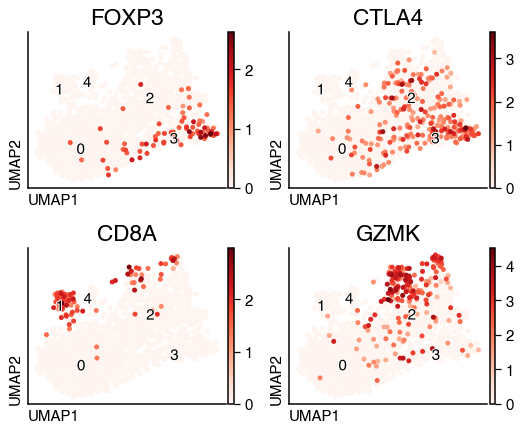

In [27]:
do.pl.umap(tcell, ["FOXP3", "CTLA4", "CD8A", "GZMK"], ncols=2, labels="leiden")

From this list of markers, we can see that cluster 1 is enriched for cytotoxic markers. We can transfer this annotation to our original object and evaluate again changes in the cell population.

... storing 'annotation_recluster' as categorical


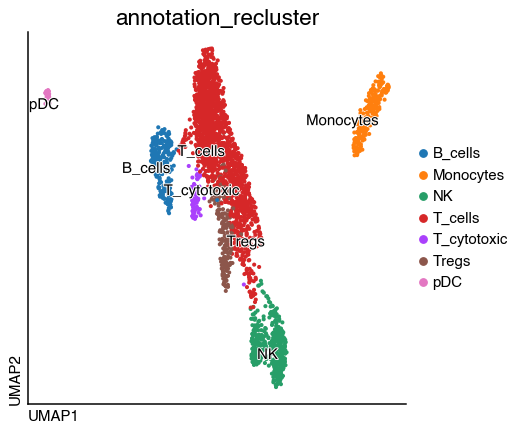

In [28]:
tcell.obs["annotation_recluster"] = tcell.obs.leiden.map(
    {"0": "T_cells", "1": "T_cytotoxic", "2": "T_cells", "3": "Tregs", "4": "T_cells"}
)
adata.obs["annotation_recluster"] = adata.obs["annotation"].copy()
do.utility.transfer_labels(
    adata_original=adata,
    adata_subset=tcell,
    original_key="annotation_recluster",
    subset_key="annotation_recluster",
    original_labels=["T_cells"],
)
do.pl.umap(adata, "annotation_recluster", labels="annotation_recluster")

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 3 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 1.37 seconds
2025-10-22 16:29:48,075 - There are 5 populations with a significant change


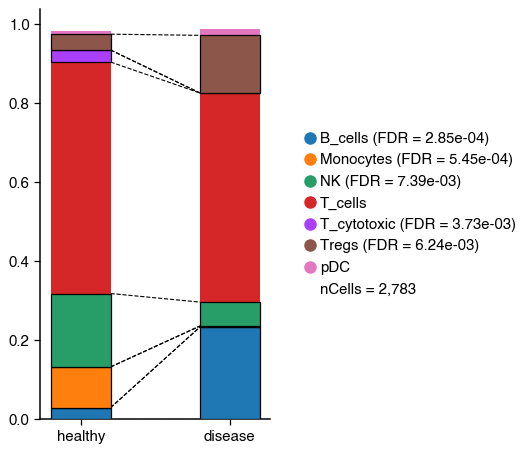

In [29]:
do.pl.cell_composition(
    adata,
    annot_key="annotation_recluster",
    cond_key="condition",
    batch_key="batch",
    transform="arcsin",
    condition_order=["healthy", "disease"],
)

We can see that even though there is a decrease in the proportion of T_cytotoxic, the change is not significant. On the other hand, the regulatory T cells increase significantly.

## Gene Ontology analysis

We can also evaluate which biological processes are enriched in a cell-type in each condition by performing gene ontology analysis. First, we need to identified differentially expressed genes. We are going to focus on T cells. We can use `do.tl.go_analysis()` to run gene set analysis using the enrichR API. This function, will split differentially express genes in up- and down-regulated and run the analysis for each set.

In [31]:
tcell = adata[adata.obs.annotation == "T_cells"]
do.tl.rank_genes_groups(
    tcell, groupby="condition", method="wilcoxon", tie_correct=True, pts=True, reference="healthy", groups=["disease"]
)
table = do.get.dge_results(tcell)
df = do.tl.go_analysis(
    table,
    gene_key="GeneName",
    pval_key="padj",
    log2fc_key="log2fc",
    log2fc_cutoff=0.25,  # It will take -0.25 and +0.25
    specie="Human",
    go_catgs=["GO_Biological_Process_2023"],
)
df.head(10)

2025-10-22 16:31:14,783 - Running GSA on Up- and Down-regulated genes


Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   Overlap       P-value  \
0       Regulation Of Apoptotic Process (GO:0042981)   115/705  3.547929e-11   
1  Positive Regulation Of Cytokine Production (GO...    65/320  9.629913e-11   
2         Regulation Of Gene Expression (GO:0010468)  162/1127  1.092209e-10   
3    Regulation Of B Cell Proliferation (GO:0030888)     20/44  1.404102e-10   
4  Positive Regulation Of Apoptotic Process (GO:0...    57/270  2.948489e-10   
5          Response To Unfolded Protein (GO:0006986)     18/44  9.314947e-09   
6  Regulation Of DNA-templated Transcription (GO:...  237/1922  1.516467e-08   
7  Negative Regulation Of Apoptotic Process (GO:0...    80/482  1.661672e-08   
8       Regulation Of B Cell Activation (GO:0050864)     13/25  3.212989e-08   
9  Antigen Receptor-Mediated Signaling Pathway (G...    33/134  3.457389e-08   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.465882e-07            0                     0    2.105323   
1      1.465882e-07            0                     0    2.722232   
2      1.465882e-07            0                     0    1.827286   
3      1.465882e-07            0                     0    8.779383   
4      2.462578e-07            0                     0    2.851035   
5      6.483203e-06            0                     0    7.284420   
6      8.673926e-06            0                     0    1.539930   
7      8.673926e-06            0                     0    2.126851   
8      1.443806e-05            0                     0   11.374688   
9      1.443806e-05            0                     0    3.453623   

   Combined Score                                              Genes     state  
0       50.658438  TFRC;ARL6IP1;CIB1;FAIM2;TNF;IKZF3;CCND2;EPC1;P...  enriched  
1       62.784364  IL21;ITK;CD40;CD80;RORA;PTPN22;TNF;PNP;PDE4B;C...  enriched  
2       41.913650  ZNF331;TFRC;NAB1;NAB2;JMJD1C;RORA;PRDM2;AHR;NR...  enriched  
3      199.173072  IL21;IL10;LYN;VAV3;CD74;CD40;MEF2C;TFRC;TNFRSF...  enriched  
4       62.564711  TOP2A;PRR7;BTG1;CTSV;TNF;ADAMTSL4;CTSL;CASP3;P...  enriched  
5      134.700912  HSPA8;PTPN1;HSP90AA1;HSP90AB1;HSPA4;RHBDD1;HSP...  enriched  
6       27.725356  ZNF296;JMJD1C;IKZF2;IKZF3;BACH1;IKZF5;SPIB;GPB...  enriched  
7       38.097973  ARF4;TFRC;ARL6IP1;CITED2;CIB1;FAIM2;MTRNR2L8;T...  enriched  
8      196.252944  IL10;FCRL3;TNFAIP3;IKZF3;SAMSN1;SUPT6H;ZFP36L2...  enriched  
9       59.333826  IGHM;ITK;PTPN22;PTPRJ;MALT1;CD79A;IGHG1;CD19;Z...  enriched

We can visualise the top terms enriched in each condition with `do.pl.split_bar_gsea()`. But we need to do a pre-filtering to only consider significant terms.

2025-10-22 16:31:32,711 - !!! Assuming GO Terms are preprocessed (Only Significant terms included)


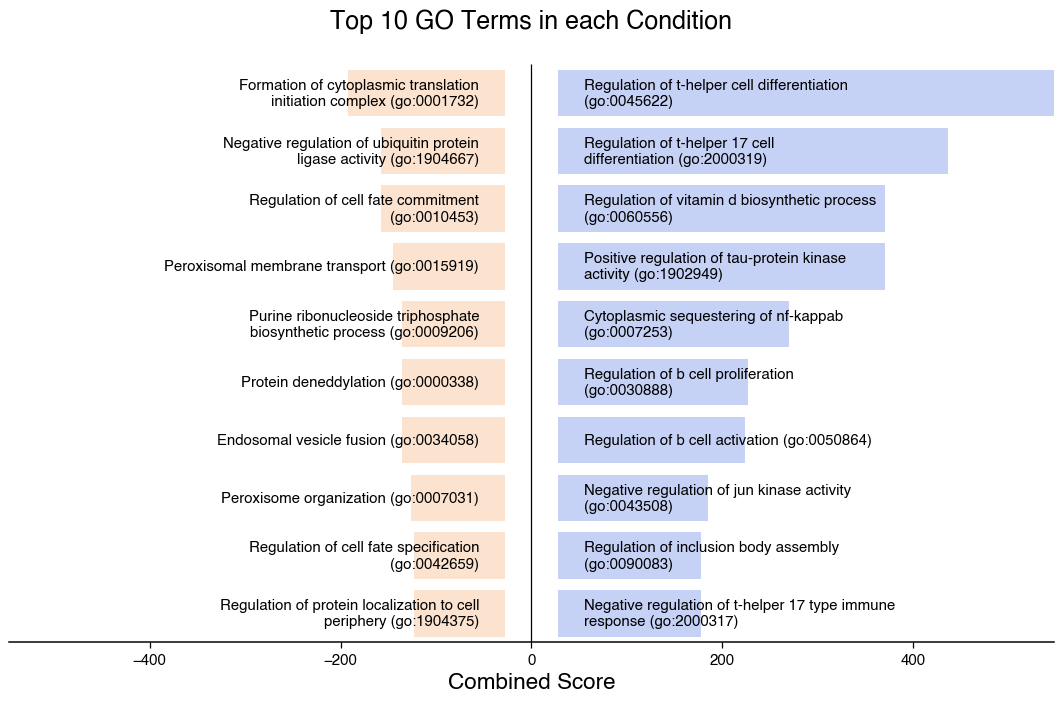

In [32]:
df_filt = df[df["Adjusted P-value"] < 0.05]
do.pl.split_bar_gsea(
    df_filt,
    term_col="Term",
    col_split="Combined Score",  # Column to use for the x-axis
    cond_col="state",  # Column that splits the up and down-regulated terms
    pos_cond="enriched",  # value in cond_col that should be in the positive axis
)

In [33]:
adata.write("/Users/david/Downloads/Data10x/adata.h5ad")

In [34]:
session_info.show(na=False, cpu=True, excludes=["backports"], std_lib=True, dependencies=True, html=True)